# CONFIGURACIÓN INICIAL

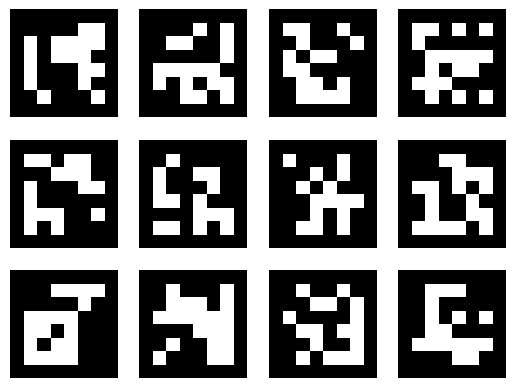

In [1]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import math
from scipy.spatial.transform import Rotation


aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 4
ny = 3
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.generateImageMarker(aruco_dict, i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("data/markers.pdf")    
plt.show()

# FUNCIÓN DE CALIBRADO

In [5]:
def calibrate_from_template(template):

    objpoints = []
    imgpoints = []

    for plantilla in glob.glob(template):
        
        # 1. Lectura de la imagen
        frame = cv2.imread(plantilla)
        
        # 2. Aplicación de ArUco
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
        parameters =  aruco.DetectorParameters()
        detector = aruco.ArucoDetector(aruco_dict, parameters)
        corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
        frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

        # 3. Lectura de ArUco
        def quad_area(data):
            l = data.shape[0]//2
            corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
            c1 = corners[:, :, 0]
            c2 = corners[:, :, 1]
            c3 = corners[:, :, 2]
            c4 = corners[:, :, 3]
            e1 = c2-c1
            e2 = c3-c2
            e3 = c4-c3
            e4 = c1-c4
            a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
            return a
        corners2 = np.array([c[0] for c in corners])
        data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                           index = pd.MultiIndex.from_product( 
                                   [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                               names = ["marker", ""] ))


        data = data.unstack().swaplevel(0, 1, axis = 1).stack()
        data["m1"] = data[["c1", "c2"]].mean(axis = 1)
        data["m2"] = data[["c2", "c3"]].mean(axis = 1)
        data["m3"] = data[["c3", "c4"]].mean(axis = 1)
        data["m4"] = data[["c4", "c1"]].mean(axis = 1)
        data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)

        # 4. Obtención de esquinas
        aruco1 = list(data.loc[(1, "c1")].values)
        aruco4 = list(data.loc[(4, "c2")].values)
        aruco12 = list(data.loc[(12, "c3")].values)
        aruco9 = list(data.loc[(9, "c4")].values)

        # 5. Puntos en la imagen
        img = np.array([
                                aruco1,     aruco4,
                                aruco9,     aruco12     
                            ], dtype=np.float32)
        imgpoints.append(img)
        
        # 6. Puntos reales
        obj = np.array([
                                    (0., 202., 0.),     (270., 202., 0.),     
                                    (0., 0., 0.),       (270., 0., 0.)    
                                ], dtype=np.float32)
        objpoints.append(obj)
        
    # 7. Transformación de los arrays de puntos
    objpoints = np.array([objpoints], dtype=np.float32)
    objpoints = np.squeeze(objpoints)
    imgpoints = np.array([imgpoints], dtype=np.float32)
    imgpoints = np.squeeze(imgpoints)

    # 8. Calibrado
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    # 9. Retorno de parámetros de la cámara
    return ret, mtx, dist, rvecs, tvecs

# FUNCIÓN DE POSICIÓN

In [6]:
def get_camera_position(image, ret, mtx, dist, rvecs, tvecs):
    
    # 1. Lectura de la imagen
    photo = cv2.imread(image)
    
    # 2. Aplicación de ArUco
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
    photo_markers = aruco.drawDetectedMarkers(photo.copy(), corners, ids)
    
    # Visualizar aruco
    plt.figure()
    plt.imshow(photo_markers)
    for i in range(len(ids)):
        c = corners[i][0]
        plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
    plt.legend()
    plt.show()
        
    # 3. Lectura de ArUco
    def quad_area(data):
        l = data.shape[0]//2
        corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
        c1 = corners[:, :, 0]
        c2 = corners[:, :, 1]
        c3 = corners[:, :, 2]
        c4 = corners[:, :, 3]
        e1 = c2-c1
        e2 = c3-c2
        e3 = c4-c3
        e4 = c1-c4
        a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
        return a

    corners2 = np.array([c[0] for c in corners])

    data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                       index = pd.MultiIndex.from_product( 
                               [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                           names = ["marker", ""] ))


    data = data.unstack().swaplevel(0, 1, axis = 1).stack()
    data["m1"] = data[["c1", "c2"]].mean(axis = 1)
    data["m2"] = data[["c2", "c3"]].mean(axis = 1)
    data["m3"] = data[["c3", "c4"]].mean(axis = 1)
    data["m4"] = data[["c4", "c1"]].mean(axis = 1)
    data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
    
    # 4. Obtención de esquinas
    aruco1 = list(data.loc[(1, "c1")].values)
    aruco4 = list(data.loc[(4, "c2")].values)
    aruco12 = list(data.loc[(12, "c3")].values)
    aruco9 = list(data.loc[(9, "c4")].values)
    
    # 5. Estimación de la posición
    im = photo
    size = im.shape

    imageWidth = size[1]
    imageHeight = size[0]
    imageSize = [imageWidth, imageHeight]

    points_2D = np.array([
                                (aruco1),     (aruco4),
                                (aruco9),     (aruco12)     
                            ])


    points_3D = np.array([
                                (0., 202., 0),  (270., 202., 0),
                                (0., 0., 0),  (270., 0., 0)    
                            ])

    success, rvecs, tvecs = cv2.solvePnP(points_3D, points_2D, mtx, dist, flags=cv2.SOLVEPNP_ITERATIVE)

    np_rodrigues = np.asarray(rvecs[:,:],np.float64)
    rmat = cv2.Rodrigues(np_rodrigues)[0]
    camera_position = -np.matrix(rmat).T @ np.matrix(tvecs)

    #Test the solvePnP by projecting the 3D Points to camera
    projPoints = cv2.projectPoints(points_3D, rvecs, tvecs, mtx, dist)[0]

    for p in points_2D:
     cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,255,0), -1)

    for p in projPoints:
     cv2.circle(im, (int(p[0][0]), int(p[0][1])), 3, (255,0,0), -1)
    
    # 6. Estimación de la rotación

    r = Rotation.from_rotvec([rvecs[0][0],rvecs[1][0],rvecs[2][0]])
    rot = r.as_euler('xyz', degrees=True)

    # 7.Resultados finales
    
    tx = camera_position[0][0]
    ty = camera_position[1][0]
    tz = camera_position[2][0]

    rx = round(180-rot[0],5) 
    ry = round(rot[1],5) 
    rz = round(rot[2],5)
    
    position = [tx, ty, tz]
    rotation = [rx, ry, rz]
    
    return position, rotation

# FUNCIONAMIENTO DEL CÓDIGO


## 1. CONFIGURACIÓN INICIAL

Es necesario ejecutarla antes del resto del código, ya que contiene todas las importaciones y configuraciones necesarias para que todo funcione.

En esta parte del código se genera el diccionario de marcadores ArUco con el que trabajaremos (del que sacaremos las referencias que utilizaremos para localizar la cámara en el espacio). Esta generación no es aleatoria, por lo que tenemos la garantía de que los marcadores que utilizamos más adelante en el código y en la experimentación son los apropiados.


## 2. FUNCIÓN DE CALIBRADO

Debe realizarse antes de la estimación de la posición. Proporciona los parámetros físicos de la cámara a partir de una colección de fotografías de la plantilla ArUco con la que estamos trabajando, en cuyas esquinas están los marcadores 1, 4, 12 y 9, en sentido de las agujas del reloj.

### Parámetros

- **template**: Cadena de texto con una expresión a partir de la cual se puedan leer todas las fotografías que se deseen usar para calibrar la cámara.

### Salida

- **ret, mtx, dist, rvecs, tvecs**: Parámetros físicos de la cámara.

### Funcionamiento

Para cada *plantilla* en la colección *template*:

1. Se lee la imagen *plantilla*.

2. Se detectan los marcadores ArUco en la imagen.

3. Se almacenan los datos de los puntos relevantes de los marcadores (vértices, punto medio de cada arista, centro del marcador).

4. Se extraen los puntos que nos interesarán para nuestro trabajo; utilizamos la esquina más externa de cada uno de los cuatro marcadores utilizados:
    - Esquina 1 (superior izquierda) del marcador 1.
    - Esquina 2 (superior derecha) del marcador 4.
    - Esquina 3 (inferior derecha) del marcador 12.
    - Esquina 4 (inferior izquierda) del marcador 9.

5. Se define un array de puntos con sus coordenadas detectadas en la imagen.

6. Se define un array de puntos con sus coordenadas medidas en la realidad.

7. Se transforman los arrays de puntos para poder trabajar con ellos en la operación de calibración.

8. Se obtienen los parámetros de la cámara con la operación calibrateCamera a partir los arrays transformados de puntos.

9. Se devuelven los parámetros ret, mtx, dist, rvecs, tvecs.


## 3. FUNCIÓN DE POSICIÓN

En esta función se utilizan los marcadores ArUco para determinar la posición y la rotación de la cámara mediante la comparación de la posición de los marcadores en la fotografía y en la realidad.

### Parámetros

- **image**: La fotografía respecto a la que queremos obtener la posición de la cámara.

- **ret, mtx, dist, rvecs, tvecs**: Parámetros físicos de la cámara obtenidos en la función de calibrado.

### Salida

- **position**: Tupla con las coordenadas de la posición de la cámara.
- **rotation**: Tupla con las coordenadas de la rotación de la cámara.

### Funcionamiento

1. Se lee *image*.

2. Se detectan los marcadores ArUco en la imagen.

3. Se almacenan los datos de los puntos relevantes de los marcadores (vértices, punto medio de cada arista, centro del marcador).

4. Se extraen los puntos que nos interesarán para nuestro trabajo; utilizamos la esquina más externa de cada uno de los cuatro marcadores utilizados:
    - Esquina 1 (superior izquierda) del marcador 1.
    - Esquina 2 (superior derecha) del marcador 4.
    - Esquina 3 (inferior derecha) del marcador 12.
    - Esquina 4 (inferior izquierda) del marcador 9.

5. Se compara la posición de los puntos en la imagen (leídos de la foto) con su posición 3D (números  fijos en la función) mediante la operación solvePnP para estimar la posición de la cámara.

6. Se estima la rotación a partir de la misma comparación.

7. Se obtienen los resultados para la salida: *position* y *rotation*.

# EXPERIMENTACIÓN

## 1. Testeo inicial de la función de posición

Antes de implementar ArUco, para comprobar la fiabilidad del algoritmo de posición de la cámara, se probó con un caso imaginario en el que la cámara se sitúa en vertical sobre el centro de un supuesto objeto cuadrado (todas las coordenadas introducidas manualmente). El ángulo obtenido concordaba con lo esperado, lo que permitió proseguir el desarrollo de ese código.

## 2. Parámetros de la cámara

En versiones anteriores del código, los parámetros de la cámara eran introducidos manualmente según las características del dispositivo. Tras investigar posibles valores para obtener resultados aceptables se descubrió que servían los parámetros obtenidos en la calibración de la cámara, cosa que ya de por sí se iba a hacer en el proyecto, por lo que se descartó completamente la forma anterior de hacerlo a favor de este modo más sencillo y más fiable.

## 3. Test inicial de ArUco (plantilla errónea)

El primer intento de detección de marcadores se realizó de forma inadvertida con una plantilla mal impresa, en la que los marcadores no se ven completamente. Esto fue suficiente para comprobar la importancia de esto, ya que, como podemos ver en el ejemplo, solo uno de los marcadores es detectado, lo que impide continuar con el algoritmo y provoca un error.

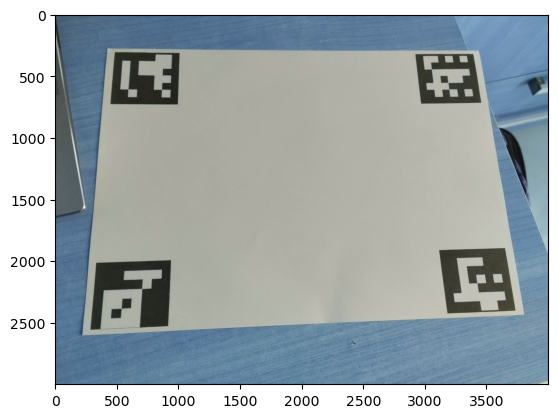

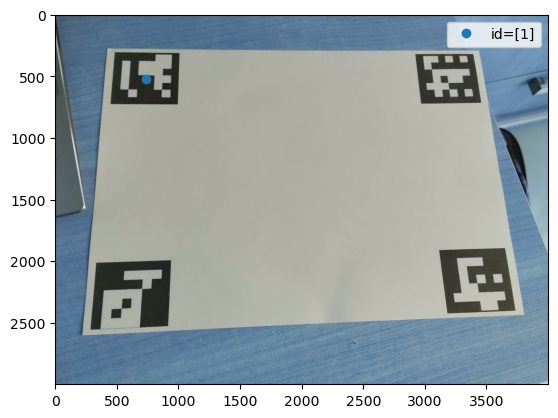

KeyError: 4

In [11]:
# Imagen con la que trabajar
image = "erronea.jpg"
# Conjunto de plantillas para el calibrado
template = "plantilla*.jpg"

# Representación de la imagen
plt.figure()
plt.imshow(cv2.imread(image))
plt.show()

# Calibrado de cámara
ret, mtx, dist, rvecs, tvecs = calibrate_from_template(template)
# Obtención de resultados y representación de la plantilla con los marcadores detectados
position, rotation = get_camera_position(image, ret, mtx, dist, rvecs, tvecs)

# Resultados
print("Posición:", position)
print("Rotación:", rotation)

## 4. Test de iluminación

En este caso se prueba la detección de marcadores ArUco con mala iluminación. Podemos observar entonces la importancia de este asunto a la hora de tomar la fotografía, ya que con poca luz puede llegar a ocurrir incluso que, como en el siguiente ejemplo, no se detecte ningún marcador y resulte en error al igual que el caso anterior.

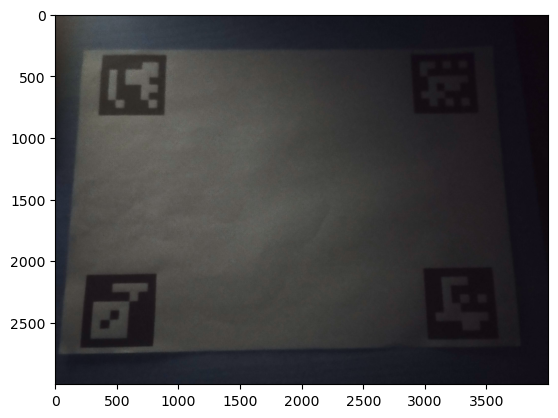

TypeError: object of type 'NoneType' has no len()

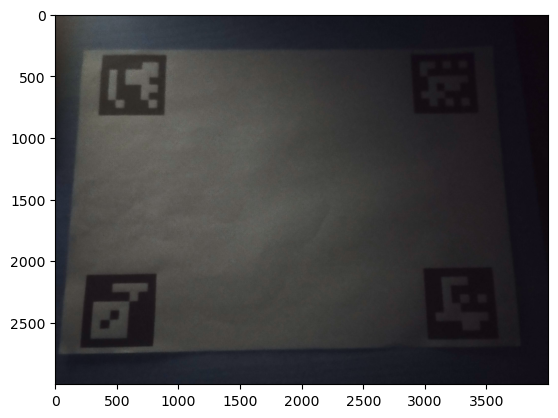

In [25]:
# Imagen con la que trabajar
image = "oscura.jpg"
# Conjunto de plantillas para el calibrado
template = "plantilla*.jpg"

# Representación de la imagen
plt.figure()
plt.imshow(cv2.imread(image))
plt.show()

# Calibrado de cámara
ret, mtx, dist, rvecs, tvecs = calibrate_from_template(template)
# Obtención de resultados y representación de la plantilla con los marcadores detectados
position, rotation = get_camera_position(image, ret, mtx, dist, rvecs, tvecs)

# Resultados
print("Posición:", position)
print("Rotación:", rotation)

## 5. Evaluación en condiciones óptimas

En este experimento, evaluamos el rendimiento del algoritmo de detección de marcadores ArUco en condiciones ideales. Se capturaron imágenes de la escena con la cámara en condiciones óptimas de iluminación y con una plantilla de marcadores ArUco correctamente impresa y colocada. El objetivo fue verificar la capacidad del algoritmo para detectar y reconocer correctamente los marcadores bajo estas condiciones controladas.

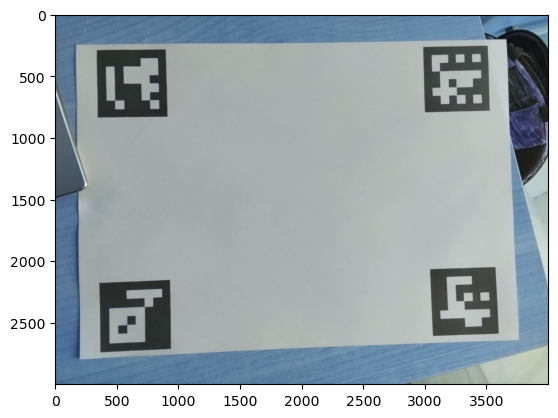

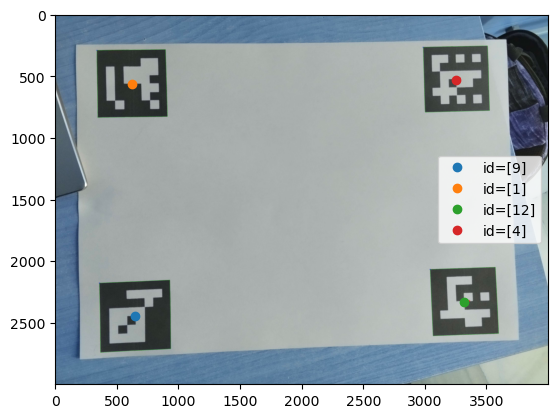

Posición: [matrix([[119.75087415]]), matrix([[102.21514717]]), matrix([[298.98342021]])]
Rotación: [359.94564, -3.5021, -1.58951]


In [15]:
# Imagen con la que trabajar
image = "plantilla5.jpg"
# Conjunto de plantillas para el calibrado
template = "plantilla*.jpg"

# Representación de la imagen
plt.figure()
plt.imshow(cv2.imread(image))
plt.show()

# Calibrado de cámara
ret, mtx, dist, rvecs, tvecs = calibrate_from_template(template)
# Obtención de resultados y representación de la plantilla con los marcadores detectados
position, rotation = get_camera_position(image, ret, mtx, dist, rvecs, tvecs)

# Resultados
print("Posición:", position)
print("Rotación:", rotation)

## 6. Evaluación en diferentes posiciones y ángulos de cámara

En este experimento, evaluamos la robustez y versatilidad del algoritmo de detección de marcadores ArUco bajo diversas condiciones. Se realizaron capturas de imágenes desde diferentes ángulos y posiciones de la cámara, así como cambios en la distancia y orientación de los marcadores ArUco. El objetivo fue analizar cómo el algoritmo respondía a estas variaciones y evaluar su capacidad para mantener una detección precisa y consistente en diferentes escenarios.

Prueba 1:


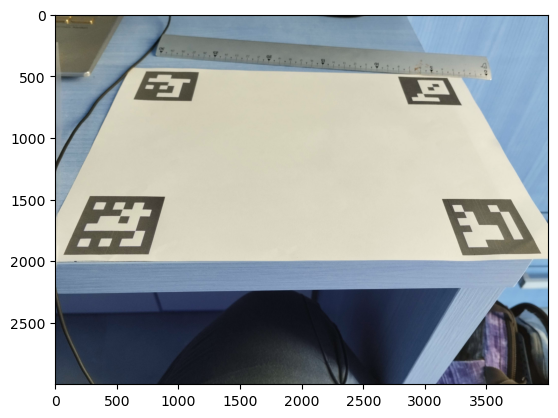

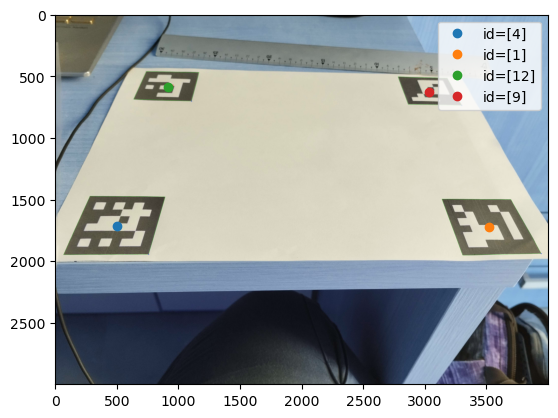

Posición: [matrix([[152.62832839]]), matrix([[359.43662211]]), matrix([[195.06398542]])]
Rotación: [313.10772, 3.29342, -179.63796]
------------------------------------------------------------------------------------------

Prueba 2:


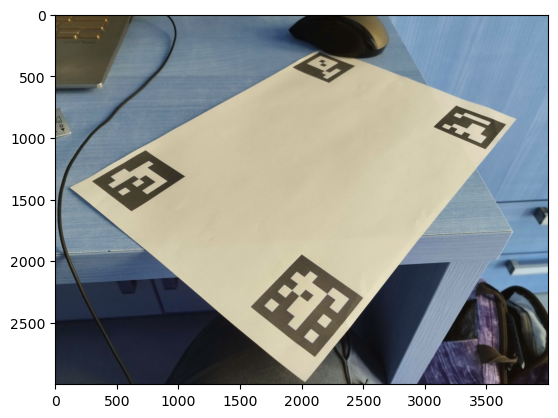

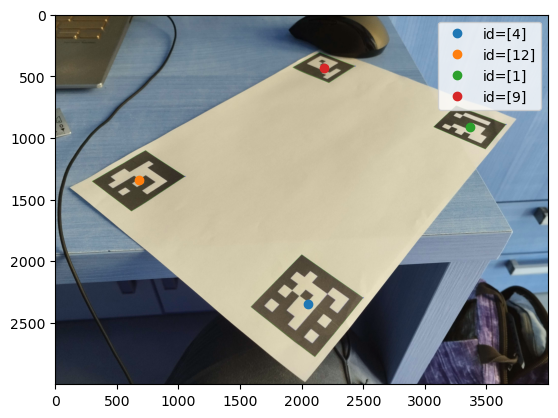

Posición: [matrix([[360.51709314]]), matrix([[259.75270974]]), matrix([[223.08607194]])]
Rotación: [328.2896, 34.74926, 139.71364]
------------------------------------------------------------------------------------------

Prueba 3:


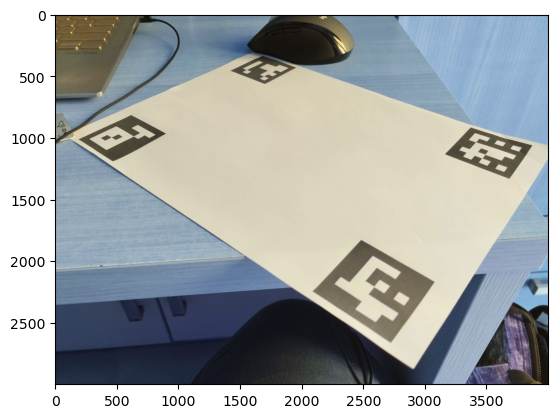

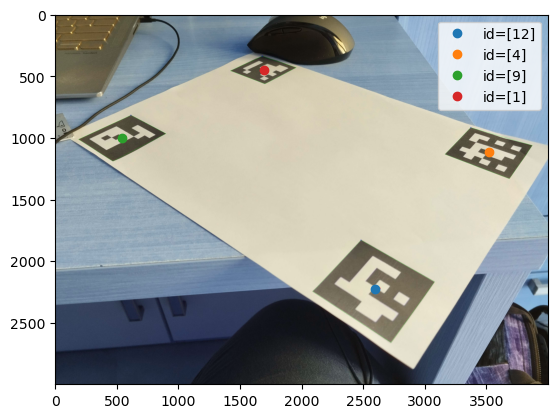

Posición: [matrix([[313.32320891]]), matrix([[-109.45364536]]), matrix([[179.25995332]])]
Rotación: [43.06779, 29.64857, 26.90095]
------------------------------------------------------------------------------------------

Prueba 4:


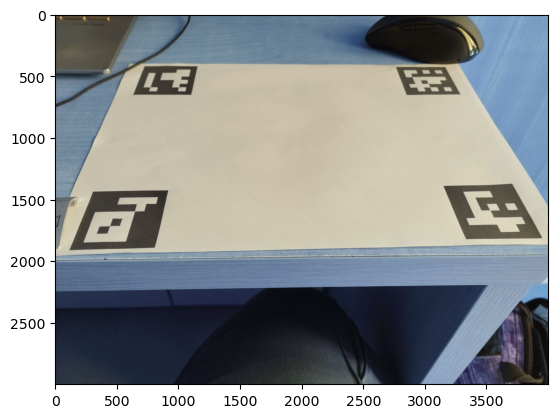

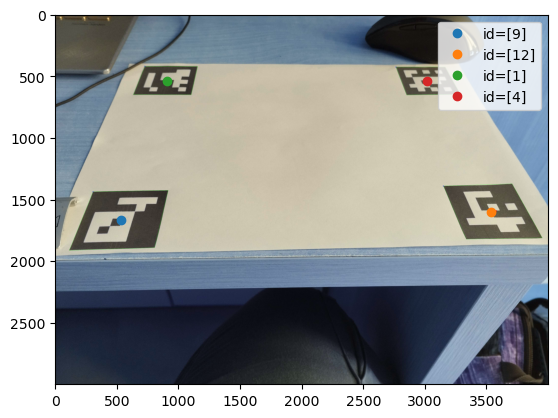

Posición: [matrix([[113.66959427]]), matrix([[-159.88798174]]), matrix([[195.65710469]])]
Rotación: [45.93995, -3.66085, -1.00399]
------------------------------------------------------------------------------------------



In [27]:
for i in range(1,5):
    print("Prueba {}:".format(i))
    # Imagen con la que trabajar
    image = "nueva{}.jpg".format(i)
    # Conjunto de plantillas para el calibrado
    template = "plantilla*.jpg"

    # Representación de la imagen
    plt.figure()
    plt.imshow(cv2.imread(image))
    plt.show()

    # Calibrado de cámara
    ret, mtx, dist, rvecs, tvecs = calibrate_from_template(template)
    # Obtención de resultados y representación de la plantilla con los marcadores detectados
    position, rotation = get_camera_position(image, ret, mtx, dist, rvecs, tvecs)

    # Resultados
    print("Posición:", position)
    print("Rotación:", rotation)
    print("------------------------------------------------------------------------------------------\n")